In [1]:
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops


import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Rescaling, Conv2D, \
                                    Dropout, MaxPooling2D,\
                                    Flatten, Dense, ReLU, Lambda

In [2]:
def preprocess_image(image):
    # Ensure image is valid
    if image is None:
        raise ValueError("Received an invalid image (None). Check file paths or input data.")

    # Convert to grayscale only if the image is not already grayscale
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Ensure image is in uint8 format
    image = np.uint8(image)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Adaptive Histogram Equalization (CLAHE) for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)

    # Apply Edge Detection (Canny)
    edges = cv2.Canny(enhanced, 50, 150)

    # Apply Binary Thresholding
    _, thresholded = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return thresholded


In [3]:
def extract_features(image):
    """Extract edge-based, texture-based, and intensity-based features from a preprocessed image."""
    features = []
    
    # Edge-based: Canny Edge Histogram
    edges = cv2.Canny(image, 50, 150)
    edge_hist = np.histogram(edges, bins=16, range=(0, 255))[0]
    features.extend(edge_hist)
    
    # Texture-based: Local Binary Pattern (LBP)
    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")
    lbp_hist = np.histogram(lbp, bins=10, range=(0, 256))[0]
    features.extend(lbp_hist)
    
    # Texture-based: Gray-Level Co-occurrence Matrix (GLCM)
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    features.extend([contrast, correlation, energy, homogeneity])
    
    # Intensity-based: Pixel Intensity Histogram
    intensity_hist = np.histogram(image, bins=16, range=(0, 255))[0]
    features.extend(intensity_hist)
    
    return np.array(features)

In [4]:
def make_pairs(genuine, forged):
    """Creates (genuine, genuine) and (genuine, forged) signature pairs after preprocessing and feature extraction."""
    gen_gen_pairs = []
    for t in itertools.combinations(genuine, 2):
        img1 = preprocess_image(t[0])
        img2 = preprocess_image(t[1])
        features1 = extract_features(img1)
        features2 = extract_features(img2)
        gen_gen_pairs.append([features1, features2])
    
    gen_forg_pairs_temp = []
    for t in itertools.product(genuine, forged):
        img1 = preprocess_image(t[0])
        img2 = preprocess_image(t[1])
        features1 = extract_features(img1)
        features2 = extract_features(img2)
        gen_forg_pairs_temp.append([features1, features2])
    
    gen_gen_pairs = np.array(gen_gen_pairs)
    gen_forg_pairs_temp = np.array(gen_forg_pairs_temp)
    
    # Pick same number of (genuine, forged) pairs as (genuine, genuine)
    gen_forg_indices = random.sample(range(len(gen_forg_pairs_temp)), len(gen_gen_pairs))
    gen_forg_pairs = [gen_forg_pairs_temp[i] for i in gen_forg_indices]
    
    gen_forg_pairs = np.array(gen_forg_pairs)
    
    return gen_gen_pairs, gen_forg_pairs

def normalize_features(X):
    """Applies Standard Scaling (Z-score) to features."""
    feature_length = X.shape[-1]  # Number of extracted features
    X_reshaped = X.reshape(-1, feature_length)  # Flatten for scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reshaped)  # Apply StandardScaler
    return X_scaled.reshape(X.shape)  # Reshape back to original format

def prepare_data(genuine, forged, X, y):
    """Prepares training data by generating pairs, extracting features, and applying normalization."""
    
    gen_gen_pairs, gen_forg_pairs = make_pairs(genuine, forged)
    all_pairs = np.concatenate((gen_gen_pairs, gen_forg_pairs), axis=0)
    print(f"All pairs shape: {all_pairs.shape}")
    
    labels = np.concatenate((np.ones(gen_gen_pairs.shape[0]), np.zeros(gen_forg_pairs.shape[0])), axis=0)
    print(f"Labels shape: {labels.shape}")
    
    # 🔹 Apply Standard Scaling
    all_pairs = normalize_features(all_pairs)

    # Shuffle Data
    combined = list(zip(all_pairs, labels))
    random.shuffle(combined)
    shuffled_pairs, shuffled_labels = zip(*combined)

    X[:] = shuffled_pairs
    y[:] = shuffled_labels

In [5]:
parent_path = "C:/Users/User/Desktop/ML Projects/archive/signatures/"

In [6]:
width = 200
height = 150
num_sig = 55
feature_length = 46  # Number of extracted features per signature
X = np.zeros((num_sig * 2 * 276, 2, feature_length), dtype=np.float32)
y = np.zeros((num_sig * 2 * 276), dtype=np.float32)

m = 0
for ind in range(1, num_sig+1):

    print(f"Iteration number {m+1}")
    genuine = np.empty((24, height, width))
    forged = np.empty((24, height, width))

    path = parent_path + "signatures_" + str(ind)

    i = 0
    j = 0
    for image in os.listdir(path):
        image_path = os.path.join(path, image)
        if os.path.isfile(image_path):
          img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
          img = 255 - img
          img = cv2.resize(img, (width, height))
          if(image.split("_")[0] == "original"):
            genuine[i] = img
            i += 1
          elif(image.split("_")[0] == "forgeries"):
            forged[j] = img
            j += 1

    #prepare_data(genuine, forged, X_train, y_train, m)
    prepare_data(genuine, forged, X[m*552:(m+1)*552], y[m*552:(m+1)*552])
    m += 1


print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}")

Iteration number 1
All pairs shape: (552, 2, 46)
Labels shape: (552,)
Iteration number 2
All pairs shape: (552, 2, 46)
Labels shape: (552,)
Iteration number 3
All pairs shape: (552, 2, 46)
Labels shape: (552,)
Iteration number 4
All pairs shape: (552, 2, 46)
Labels shape: (552,)
Iteration number 5
All pairs shape: (552, 2, 46)
Labels shape: (552,)
Iteration number 6
All pairs shape: (552, 2, 46)
Labels shape: (552,)
Iteration number 7
All pairs shape: (552, 2, 46)
Labels shape: (552,)
Iteration number 8
All pairs shape: (552, 2, 46)
Labels shape: (552,)
Iteration number 9
All pairs shape: (552, 2, 46)
Labels shape: (552,)
Iteration number 10
All pairs shape: (552, 2, 46)
Labels shape: (552,)
Iteration number 11
All pairs shape: (552, 2, 46)
Labels shape: (552,)
Iteration number 12
All pairs shape: (552, 2, 46)
Labels shape: (552,)
Iteration number 13
All pairs shape: (552, 2, 46)
Labels shape: (552,)
Iteration number 14
All pairs shape: (552, 2, 46)
Labels shape: (552,)
Iteration numbe

In [7]:
def visualize(pairs, labels, to_show=6):
    """Visualizes the feature distributions of signature pairs instead of images."""

    num_pairs = min(to_show, len(pairs))  # Ensure we don't exceed dataset size
    fig, axes = plt.subplots(num_pairs, 1, figsize=(10, 4 * num_pairs))

    if num_pairs == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i in range(num_pairs):
        n = np.random.randint(0, len(pairs))  # Pick a random sample
        feature_1 = pairs[n][0]  # First signature feature vector
        feature_2 = pairs[n][1]  # Second signature feature vector

        # Plot histogram of features
        axes[i].hist(feature_1, bins=20, alpha=0.5, label="Feature Vector 1")
        axes[i].hist(feature_2, bins=20, alpha=0.5, label="Feature Vector 2")
        axes[i].legend()
        axes[i].set_xlabel("Feature Value")
        axes[i].set_ylabel("Frequency")
        axes[i].set_title(f"Feature Distribution for Pair {n} (Label: {'Genuine' if labels[n] == 1 else 'Forged'})")

    plt.tight_layout()
    plt.show()


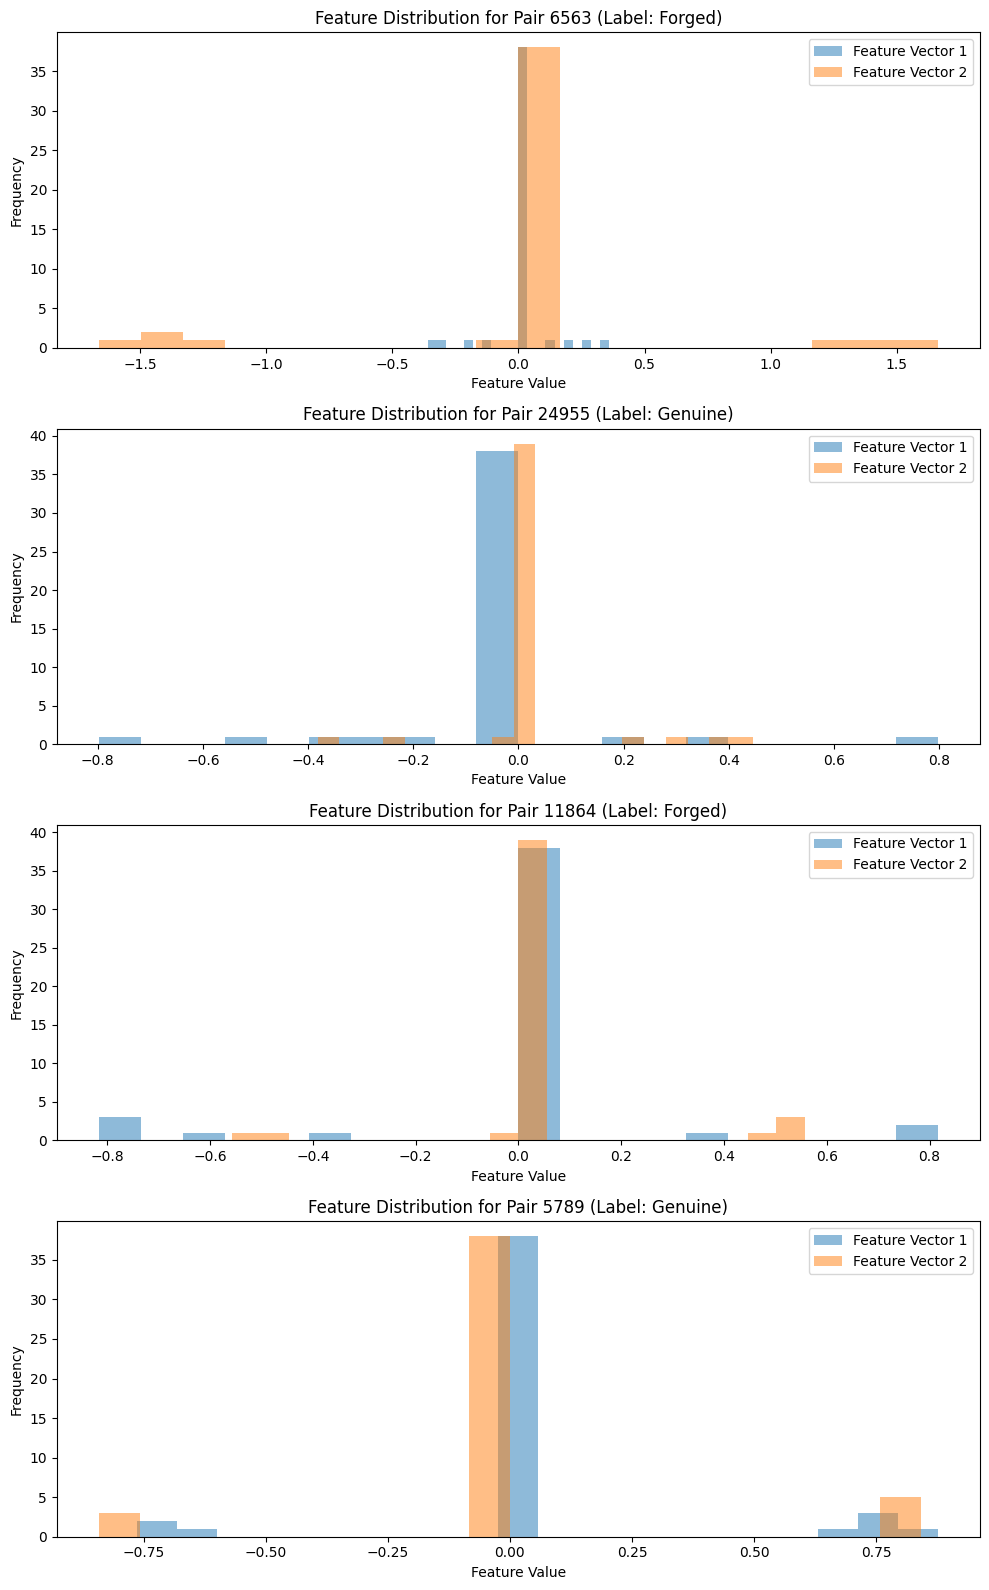

In [8]:
visualize(X, y, to_show=4)

In [9]:
np.save("X.npy", X)  # Saves in the current directory
np.save("y.npy", y)  # Saves in the current directory

In [10]:
import numpy as np

X_loaded = np.load("X.npy")

print("X shape:", X_loaded.shape)  # Should be (30360, 2, 46)
print("Min value in X:", X_loaded.min())  # Should be ~0
print("Max value in X:", X_loaded.max())  # Should be ~1
print("Mean value in X:", X_loaded.mean())  # Should be around 0.1 - 0.3 if well-distributed
print("Standard deviation in X:", X_loaded.std())  # Should not be too close to 0


X shape: (30360, 2, 46)
Min value in X: 0.0
Max value in X: 10.308986
Mean value in X: 1.1935744
Standard deviation in X: 3.0260212


In [21]:
print("X shape:", X.shape)  # Should be (30360, 2, height, width)
print("y shape:", y.shape)  # Should be (30360,)

# Check pixel intensity distribution
print("Min pixel value:", X.min())  # Should be 0
print("Max pixel value:", X.max())  # Should be 255
print("Mean pixel value:", X.mean())  # Should be near 127 if balanced

# Check labels
unique, counts = np.unique(y, return_counts=True)
print("Label distribution:", dict(zip(unique, counts)))  # Should be ~15180 each for genuine and forged


X shape: (30360, 2, 150, 200)
y shape: (30360,)
Min pixel value: 0
Max pixel value: 255
Mean pixel value: 11.274959247364954
Label distribution: {np.uint8(0): np.int64(15180), np.uint8(1): np.int64(15180)}


In [7]:
width = 200
height = 150
channels = 1
input_shape = (height, width, channels)

In [8]:
def load_data():
    X = np.load("C:/Users/User/Desktop/ML Projects/X.npy")
    print(X.shape)
    y = np.load("C:/Users/User/Desktop/ML Projects/y.npy")
    print(y.shape)

    X_t, X_test, y_t, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    print(X_t.shape)
    print(y_t.shape)
    print(X_test.shape)
    print(y_test.shape)

    del X
    del y

    X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size = 0.2, random_state = 42)
    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)

    del X_t
    del y_t

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_data()

(30360, 2, 150, 200)
(30360,)
(21252, 2, 150, 200)
(21252,)
(9108, 2, 150, 200)
(9108,)
(17001, 2, 150, 200)
(17001,)
(4251, 2, 150, 200)
(4251,)


In [9]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]
        
        n = random.randint(0, pairs.shape[0])
        print(f"Index to show: {n}")
        ax.imshow(np.concatenate([pairs[n][0], pairs[n][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[n], predictions[n][0]))
        else:
            ax.set_title("Label: {}".format(labels[n]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

Index to show: 16173
Index to show: 12348
Index to show: 881
Index to show: 4182


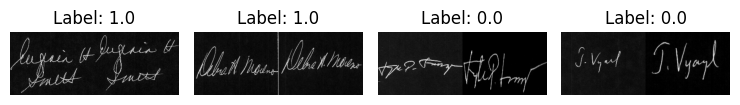

In [10]:
visualize(X_train[:-1], y_train[:-1], to_show = 4, num_col = 4)

Index to show: 2582
Index to show: 2049
Index to show: 2234
Index to show: 3189


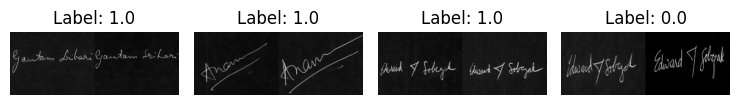

In [11]:
visualize(X_val[:-1], y_val[:-1], to_show = 4, num_col = 4)

Index to show: 1658
Index to show: 936
Index to show: 2100
Index to show: 1607


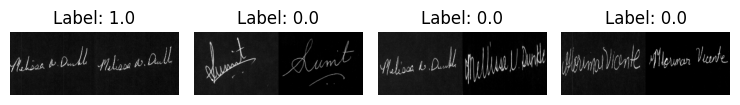

In [12]:
visualize(X_test[:-1], y_test[:-1], to_show = 4, num_col = 4)

In [13]:
def siamese_network(input_shape):
    input = Input(input_shape)

    x = Rescaling(1/255)(input)

    x = Conv2D(64, (11, 11), activation = "relu")(input)
    x = Lambda(tf.nn.local_response_normalization)(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)

    x = Conv2D(128, (7, 7), activation = "relu")(x)
    x = Lambda(tf.nn.local_response_normalization)(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (5, 5), activation = "relu")(x)

    x = Conv2D(512, (3, 3), activation = "relu")(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)

    x = Dense(1024, activation = "relu")(x)
    x = Dropout(0.5)(x)

    x = Flatten()(x)

    x = Dense(128, activation = "relu")(x)

    model = Model(input, x)

    return model

def euclidean_distance(vecs):
    (imgA, imgB) = vecs
    sum_square = K.sum(K.square(imgA - imgB), axis = 1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [14]:
imageA = Input(input_shape)
imageB = Input(input_shape)

siamese = siamese_network(input_shape)

modelA = siamese(imageA)
modelB = siamese(imageB)

distance = Lambda(euclidean_distance, output_shape=(1,))([modelA, modelB])

output = Dense(1, activation = "sigmoid")(distance)

model = Model(inputs = [imageA, imageB], outputs = output)

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 150, 200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │ 35,309,184 │ input_layer[0][0… │
│ (Functional)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ lambda_2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,309,186 (134.69 MB)

 Trainable params: 35,309,186 (134.69 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
batch_size = 64
epochs = 20
early_stopping = EarlyStopping(monitor = "val_loss", patience = 5, verbose = 1)

history = model.fit([X_train[:, 0, :, :], X_train[:, 1, :, :]], y_train,
                    validation_data = ([X_val[:, 0, :, :], X_val[:, 1, :, :]], y_val),
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = [early_stopping],
                    verbose = 1)

Epoch 1/20
131/266 ━━━━━━━━━━━━━━━━━━━━ 27:04 12s/step - accuracy: 0.7931 - loss: 0.4132

KeyboardInterrupt: 